In [1]:

import pandas as pd                
import numpy as np                 
import matplotlib.pyplot as plt    
import seaborn as sns              
sns.set()


In [2]:
df = pd.read_csv('indian_credit_risk_dataset python project.csv')
print(df.shape)    
df.head()         
df.info()     


(3000, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            3000 non-null   int64  
 1   age                    3000 non-null   int64  
 2   gender                 3000 non-null   object 
 3   education_level        3000 non-null   object 
 4   marital_status         3000 non-null   object 
 5   employment_status      3000 non-null   object 
 6   annual_income_INR      3000 non-null   float64
 7   credit_score           3000 non-null   int64  
 8   loan_amount_INR        3000 non-null   float64
 9   loan_term_months       3000 non-null   int64  
 10  interest_rate_percent  3000 non-null   float64
 11  existing_loans_count   3000 non-null   int64  
 12  num_dependents         3000 non-null   int64  
 13  loan_purpose           3000 non-null   object 
 14  state                  3000 non-null   object

#  Data Profiling and Cleaning

In [3]:
df.isnull().sum()       
df.describe()           
df['state'].value_counts()  


state
Bihar            891
Uttar Pradesh    535
Maharashtra      330
West Bengal      258
Karnataka        211
Gujarat          183
Tamil Nadu       176
Rajasthan        174
Telangana        151
Delhi             91
Name: count, dtype: int64

# Exploratory Data Analysis

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


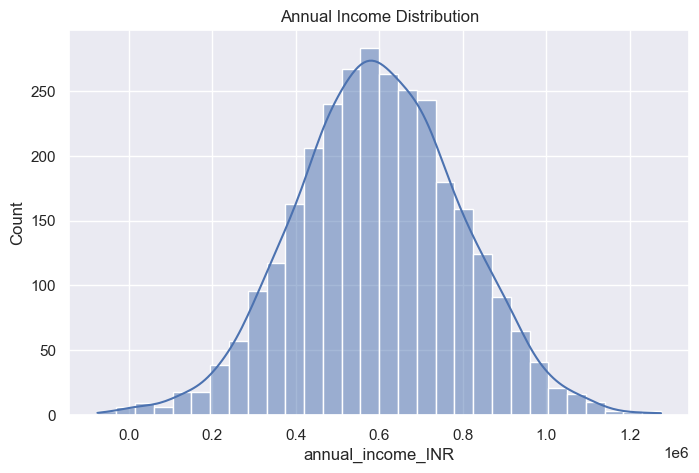

In [4]:

plt.figure(figsize=(8,5))
sns.histplot(df['annual_income_INR'], bins=30, kde=True)
plt.title('Annual Income Distribution')
plt.show()


# Log‑Transform Skewed Numericals

In [6]:

skewed_cols = ['annual_income_INR', 'loan_amount_INR', 'debt_to_income_ratio']
for col in skewed_cols:
    df[f'log_{col}'] = np.log1p(df[col])


C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Binning Continuous Risk Indicators

In [7]:

df['cs_band'] = pd.cut(df['credit_score'],
                      bins=[300, 550, 650, 750, 900],
                      labels=['low', 'near-prime', 'prime', 'super-prime'])
df['dti_band'] = pd.cut(df['debt_to_income_ratio'],
                       bins=[0, 0.2, 0.4, 0.6, 1.0, np.inf],
                       labels=['very_low', 'low', 'medium', 'high', 'very_high'])


 # One‑Hot Encoding for Core Categoricals

In [8]:

ohe_cols = ['gender', 'marital_status', 'employment_status', 'cs_band', 'dti_band']
df = pd.get_dummies(df, columns=ohe_cols, drop_first=True)


# Target Encoding for High-Cardinality Fields

In [9]:

for col in ['state', 'loan_purpose']:
    target_mean = df.groupby(col)['is_default'].mean()
    df[f'{col}_te'] = df[col].map(target_mean)

df.drop(['state', 'loan_purpose'], axis=1, inplace=True)


# Interaction Features

In [10]:

df['cs_dti_interaction'] = df['credit_score'] * df['debt_to_income_ratio']


# Insigts and Business Quetions 

#### Q 1) How do default rates and average loan sizes vary across different age buckets (e.g. 21–30, 31–40, 41–50, 51+)?

C:\Users\Acer\AppData\Local\Temp\ipykernel_5280\547663736.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('age_bucket')
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals

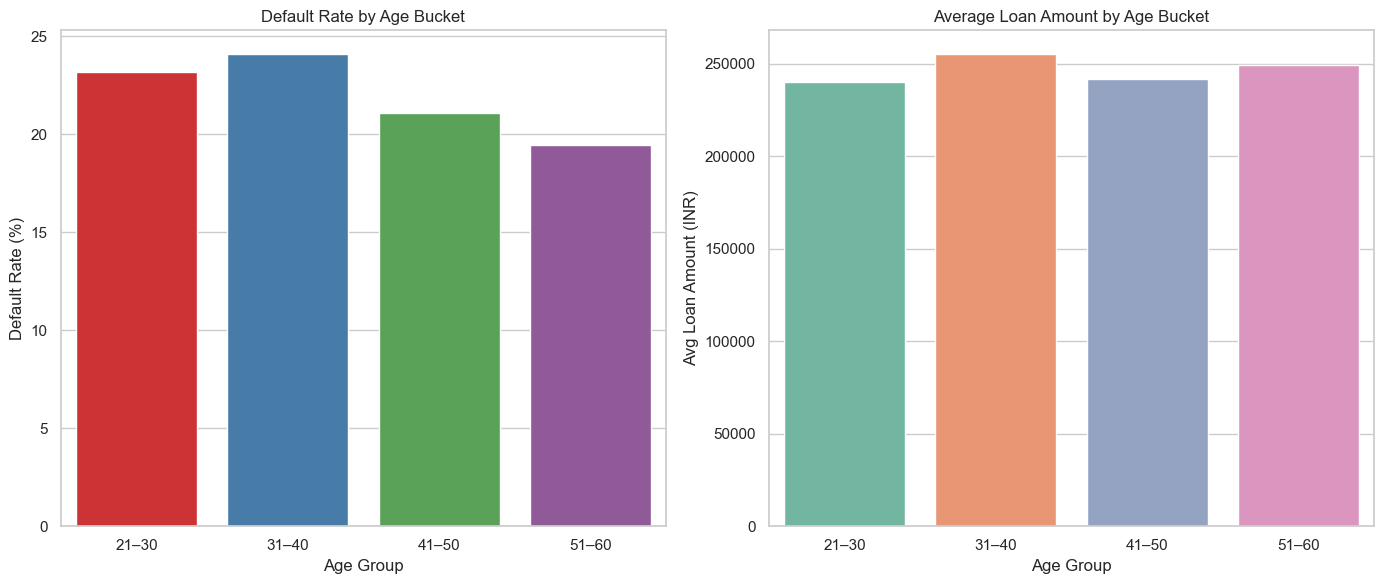

In [16]:



age_bins   = [20, 30, 40, 50, 60]
age_labels = ['21–30', '31–40', '41–50', '51–60']
df['age_bucket'] = pd.cut(
    df['age'],          
    bins=age_bins,
    labels=age_labels,
    right=True          
)


age_metrics = (
    df
    .groupby('age_bucket')
    .agg(
        default_rate    = ('is_default',   'mean'),  
        avg_loan_amount = ('loan_amount_INR', 'mean'),
        count           = ('customer_id', 'count')   
    )
    .reset_index()
)


age_metrics['default_rate'] *= 100


sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Default Rate plot
sns.barplot(
    data=age_metrics,
    x='age_bucket', 
    y='default_rate',
    palette='Set1',
    ax=ax1
)
ax1.set_title('Default Rate by Age Bucket')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Default Rate (%)')


sns.barplot(
    data=age_metrics,
    x='age_bucket', 
    y='avg_loan_amount',
    palette='Set2',
    ax=ax2
)
ax2.set_title('Average Loan Amount by Age Bucket')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Avg Loan Amount (INR)')

plt.tight_layout()
plt.show()


#### Q2) What’s the relationship between annual income bands and average loan amount, and do higher‑income borrowers get better interest rates?

C:\Users\Acer\AppData\Local\Temp\ipykernel_5280\738071703.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('income_band')
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = val

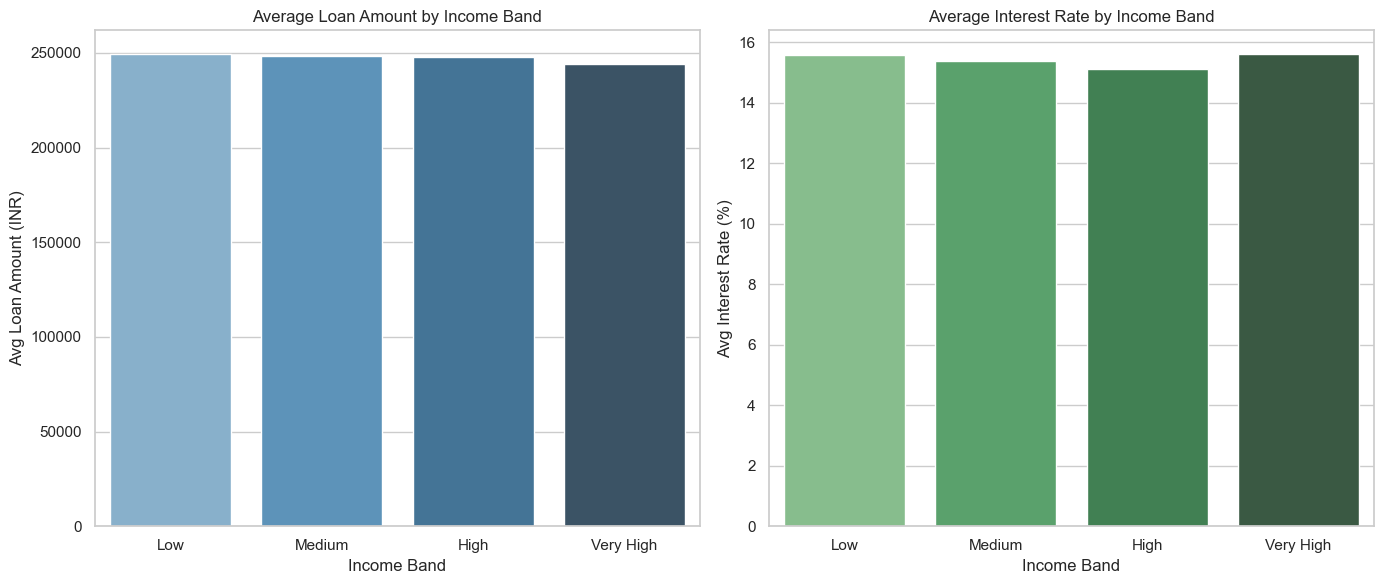

In [17]:



df['income_band'] = pd.qcut(
    df['annual_income_INR'],   
    q=4,                       
    labels=['Low', 'Medium', 'High', 'Very High']
)


income_metrics = (
    df
    .groupby('income_band')
    .agg(
        avg_loan_amount   = ('loan_amount_INR',       'mean'),
        avg_interest_rate = ('interest_rate_percent', 'mean'),
        count             = ('customer_id',           'count')
    )
    .reset_index()
)



sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


sns.barplot(
    data=income_metrics,
    x='income_band',
    y='avg_loan_amount',
    palette='Blues_d',
    ax=ax1
)
ax1.set_title('Average Loan Amount by Income Band')
ax1.set_xlabel('Income Band')
ax1.set_ylabel('Avg Loan Amount (INR)')


sns.barplot(
    data=income_metrics,
    x='income_band',
    y='avg_interest_rate',
    palette='Greens_d',
    ax=ax2
)
ax2.set_title('Average Interest Rate by Income Band')
ax2.set_xlabel('Income Band')
ax2.set_ylabel('Avg Interest Rate (%)')

plt.tight_layout()
plt.show()


#### Q3 How do distributions of credit score, debt‑to‑income ratio, and default rate differ by education level and employment status?

Raw columns: ['customer_id', 'age', 'gender', 'education_level', 'marital_status', 'employment_status', 'annual_income_INR', 'credit_score', 'loan_amount_INR', 'loan_term_months', 'interest_rate_percent', 'existing_loans_count', 'num_dependents', 'loan_purpose', 'state', 'debt_to_income_ratio', 'is_default']
Cleaned columns: ['customer_id', 'age', 'gender', 'education_level', 'marital_status', 'employment_status', 'annual_income_INR', 'credit_score', 'loan_amount_INR', 'loan_term_months', 'interest_rate_percent', 'existing_loans_count', 'num_dependents', 'loan_purpose', 'state', 'debt_to_income_ratio', 'is_default']


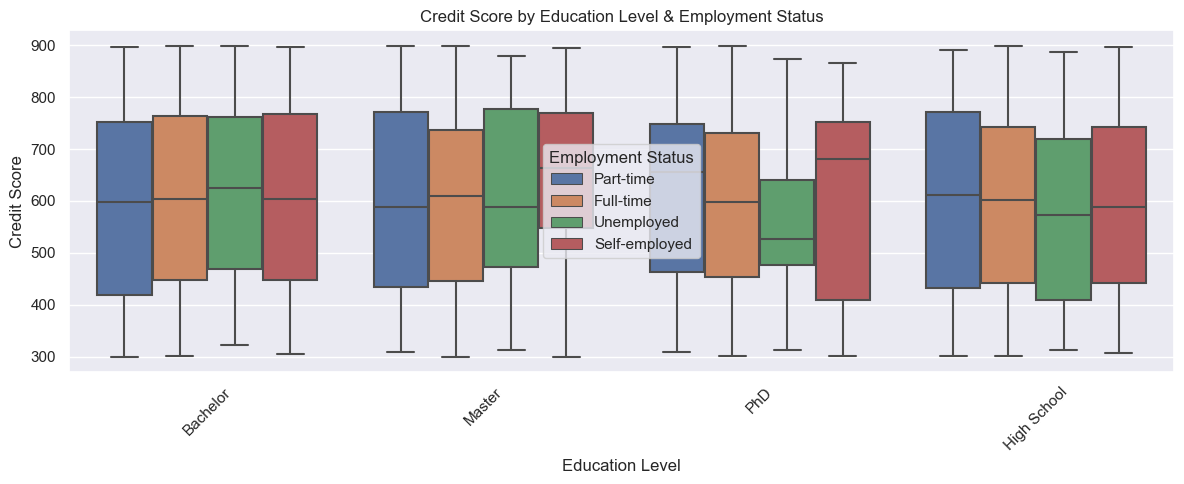

C:\Users\Acer\AppData\Local\Temp\ipykernel_8940\3804431496.py:35: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


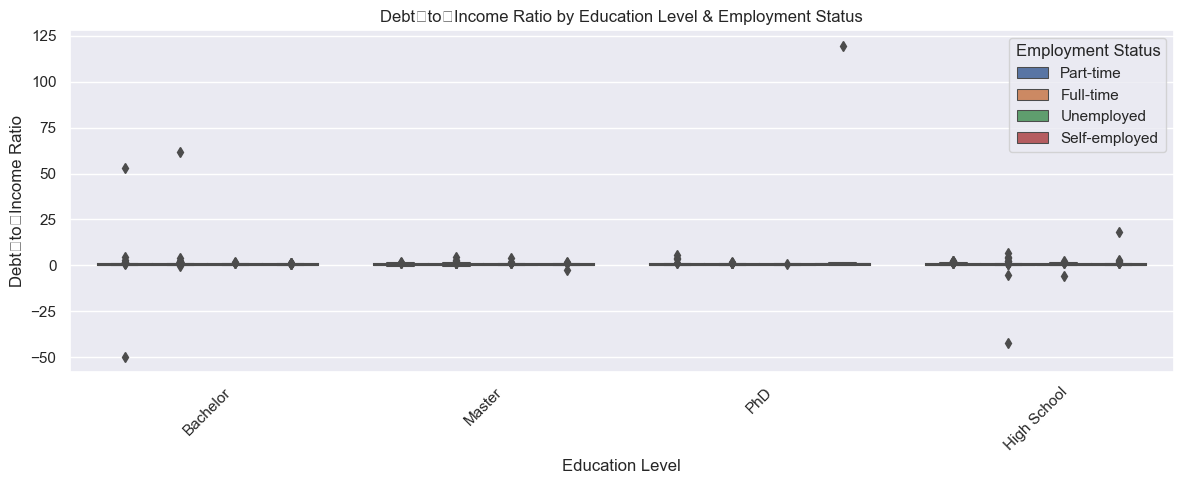

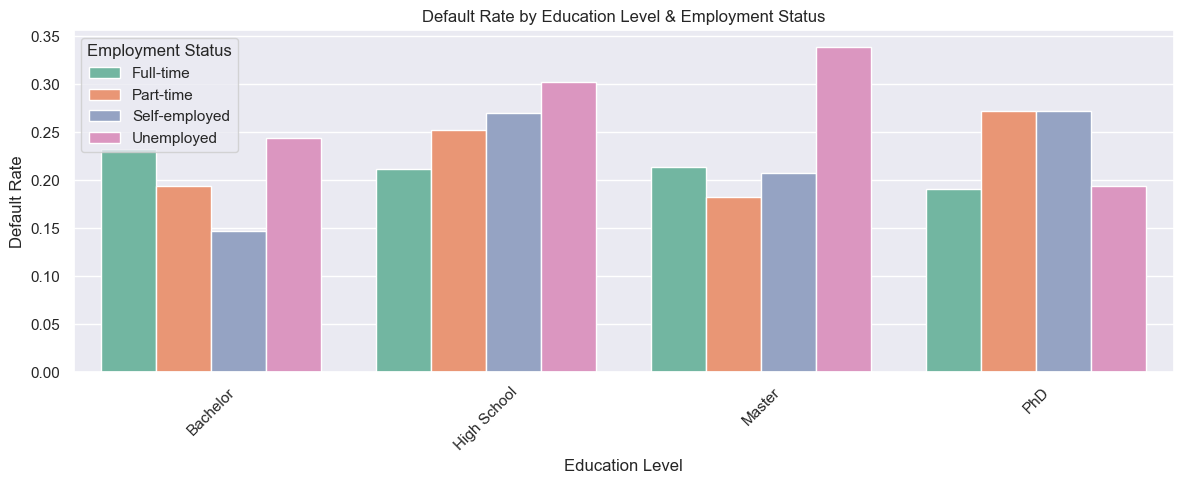

In [4]:

print("Raw columns:", df.columns.tolist())


df.columns = df.columns.str.strip()
print("Cleaned columns:", df.columns.tolist())


plt.figure(figsize=(12, 5))
sns.boxplot(
    data=df,
    x='education_level',
    y='credit_score',
    hue='employment_status'
)
plt.title('Credit Score by Education Level & Employment Status')
plt.xlabel('Education Level')
plt.ylabel('Credit Score')
plt.xticks(rotation=45)
plt.legend(title='Employment Status')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(
    data=df,
    x='education_level',
    y='debt_to_income_ratio',
    hue='employment_status'
)
plt.title('Debt‑to‑Income Ratio by Education Level & Employment Status')
plt.xlabel('Education Level')
plt.ylabel('Debt‑to‑Income Ratio')
plt.xticks(rotation=45)
plt.legend(title='Employment Status')
plt.tight_layout()
plt.show()


default_rate_df = (
    df
    .groupby(['education_level', 'employment_status'], as_index=False)
    .agg(default_rate=('is_default', 'mean'))
)

plt.figure(figsize=(12, 5))
sns.barplot(
    data=default_rate_df,
    x='education_level',
    y='default_rate',
    hue='employment_status',
    palette='Set2'
)
plt.title('Default Rate by Education Level & Employment Status')
plt.xlabel('Education Level')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.legend(title='Employment Status')
plt.tight_layout()
plt.show()


#### Q4 Which states have the highest loan uptake, and how do their default rates and mean interest rates compare?

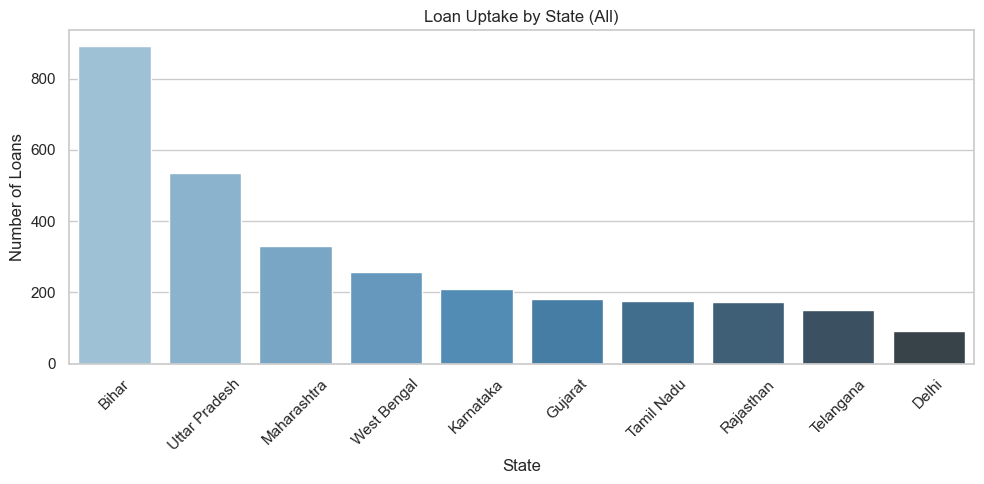

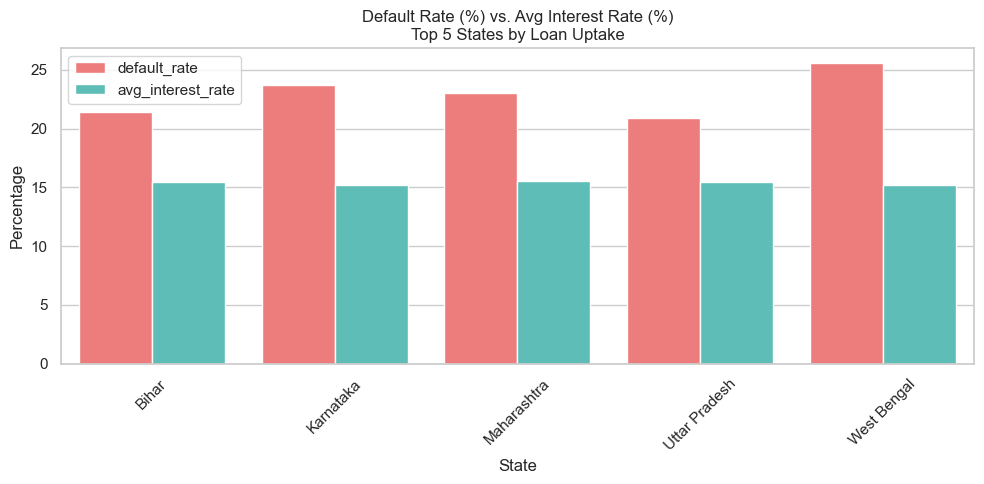

In [5]:



state_metrics = (
    df
    .groupby('state', as_index=False)
    .agg(
        loan_count         = ('customer_id',          'count'),
        default_rate       = ('is_default',           'mean'),
        avg_interest_rate  = ('interest_rate_percent','mean')
    )
)


state_metrics['default_rate'] *= 100


top_states = (
    state_metrics
    .nlargest(5, 'loan_count')
    ['state']
    .tolist()
)

top_metrics = state_metrics[state_metrics['state'].isin(top_states)]


sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
order = state_metrics.sort_values('loan_count', ascending=False)['state']
sns.barplot(
    data=state_metrics,
    x='state',
    y='loan_count',
    order=order,
    palette='Blues_d'
)
plt.title('Loan Uptake by State (All)')
plt.xlabel('State')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



melted = (
    top_metrics
    .melt(id_vars='state',
          value_vars=['default_rate','avg_interest_rate'],
          var_name='metric',
          value_name='value')
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=melted,
    x='state',
    y='value',
    hue='metric',
    palette=['#FF6B6B','#4ECDC4']
)
plt.title('Default Rate (%) vs. Avg Interest Rate (%)\nTop 5 States by Loan Uptake')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.legend(title='')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Q5) How does the number of dependents and existing loans correlate with debt‑to‑income ratio and default probability?

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


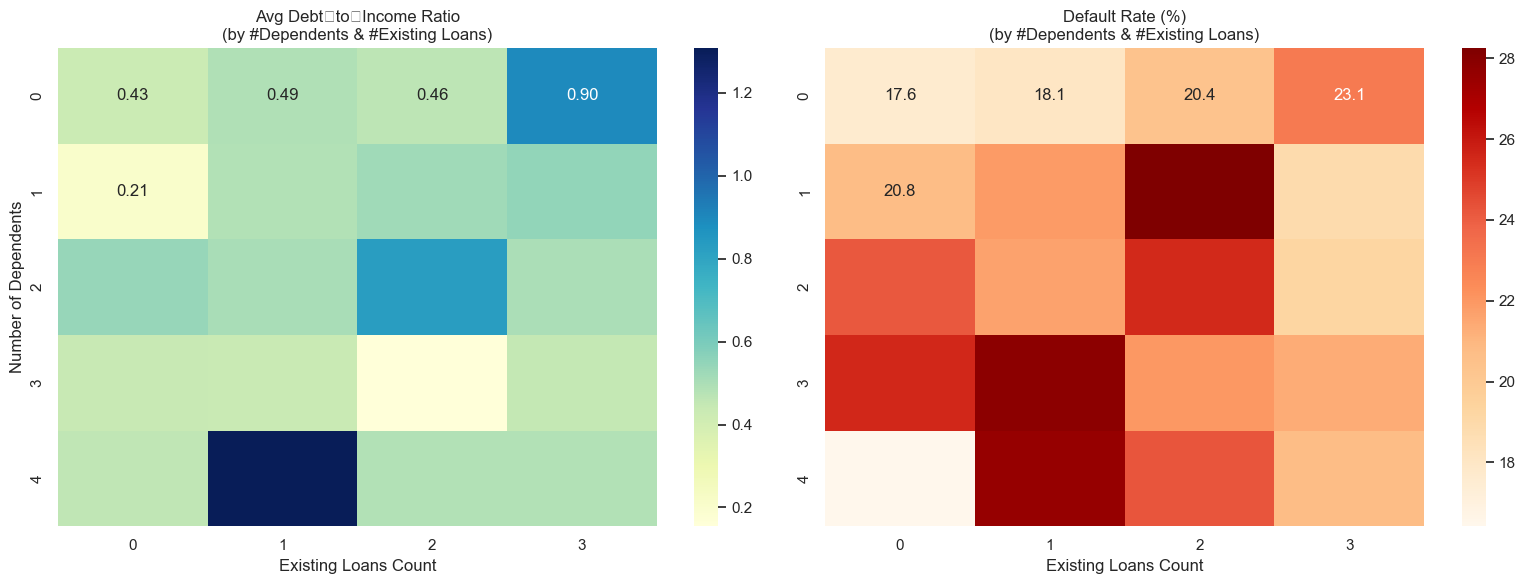

In [6]:



dti_pivot = df.pivot_table(
    index='num_dependents',
    columns='existing_loans_count',
    values='debt_to_income_ratio',
    aggfunc='mean'
)

default_pivot = df.pivot_table(
    index='num_dependents',
    columns='existing_loans_count',
    values='is_default',
    aggfunc='mean'
) * 100  # convert fraction to percentage


sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


sns.heatmap(
    dti_pivot,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    ax=ax1
)
ax1.set_title("Avg Debt‑to‑Income Ratio\n(by #Dependents & #Existing Loans)")
ax1.set_xlabel("Existing Loans Count")
ax1.set_ylabel("Number of Dependents")


sns.heatmap(
    default_pivot,
    annot=True,
    fmt=".1f",
    cmap="OrRd",
    ax=ax2
)
ax2.set_title("Default Rate (%)\n(by #Dependents & #Existing Loans)")
ax2.set_xlabel("Existing Loans Count")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()


#### Q6) What are the most common loan purposes (Home, Car, Education, Business, Personal) across credit‑score segments, and which purposes have the highest default rates?

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Acer\AppData\Local\Temp\ipykernel_8940\3847398020.py:22: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from curren

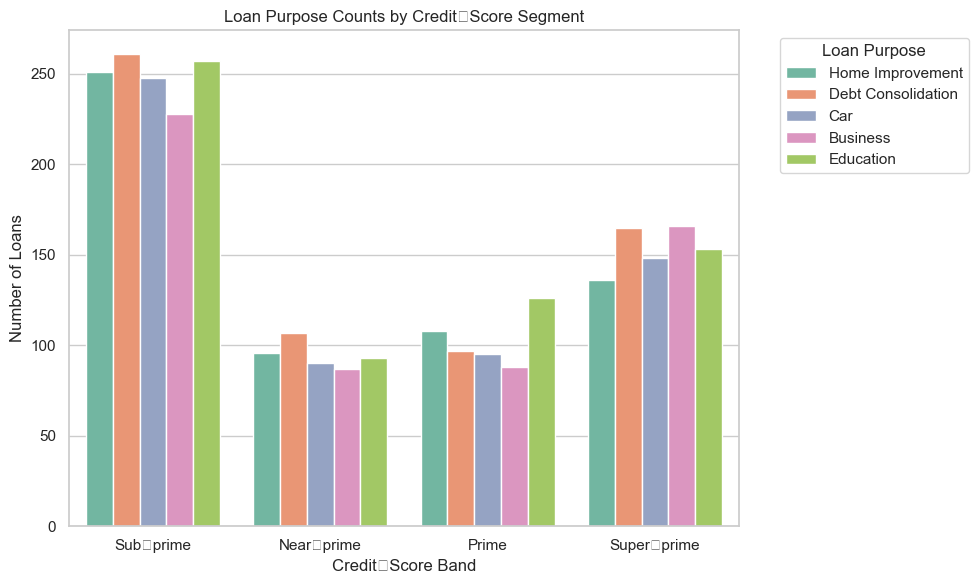

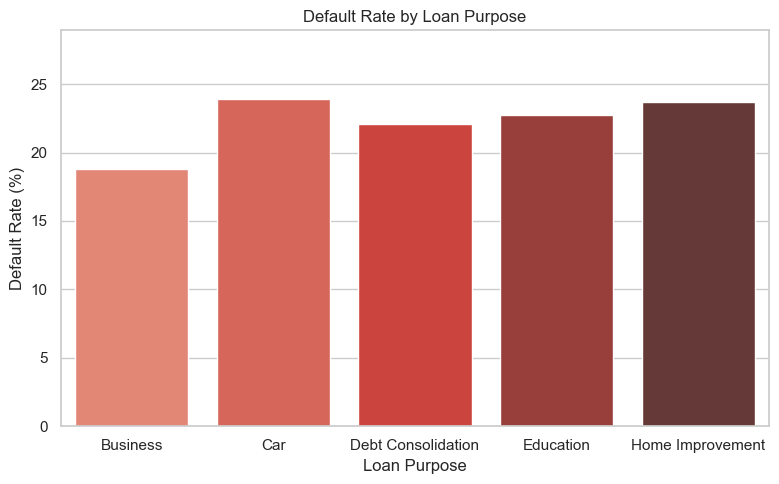

In [7]:



bins  = [300, 550, 650, 750, 900]
labels = ['Sub‑prime','Near‑prime','Prime','Super‑prime']
df['cs_band'] = pd.cut(
    df['credit_score'], 
    bins=bins, 
    labels=labels, 
    right=False    # so 300–549→Sub‑prime, etc.
)


plt.figure(figsize=(10,6))
sns.countplot(
    data=df,
    x='cs_band', 
    hue='loan_purpose', 
    palette='Set2'
)
plt.title('Loan Purpose Counts by Credit‑Score Segment')
plt.xlabel('Credit‑Score Band')
plt.ylabel('Number of Loans')
plt.legend(title='Loan Purpose', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


dr = (
    df
    .groupby('loan_purpose', as_index=False)
    .agg(default_rate=('is_default','mean'))
)
dr['default_rate'] *= 100  # to percentage


plt.figure(figsize=(8,5))
sns.barplot(
    data=dr,
    x='loan_purpose', 
    y='default_rate', 
    palette='Reds_d'
)
plt.title('Default Rate by Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Default Rate (%)')
plt.ylim(0, dr['default_rate'].max() + 5)
plt.tight_layout()
plt.show()


#### Q7) How do default rates and average interest rates vary by loan term (12, 24, 36, 48, 60 months)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


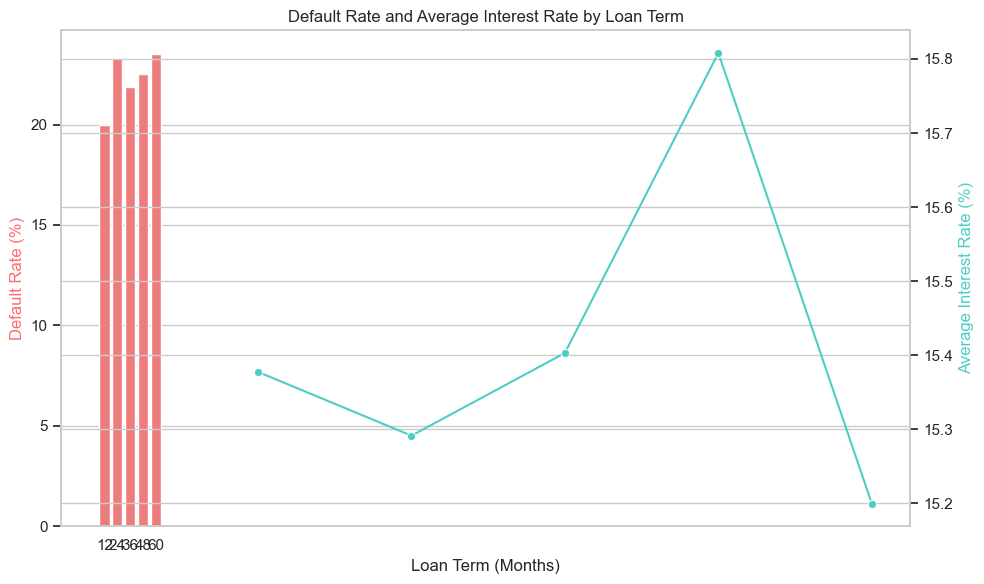

In [8]:

loan_metrics = (
    df
    .groupby('loan_term_months')
    .agg(
        default_rate=('is_default', 'mean'),
        avg_interest_rate=('interest_rate_percent', 'mean')
    )
    .reset_index()
)
loan_metrics['default_rate'] *= 100  


sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))


sns.barplot(
    data=loan_metrics,
    x='loan_term_months',
    y='default_rate',
    ax=ax1,
    color='#FF6B6B'
)
ax1.set_xlabel('Loan Term (Months)')
ax1.set_ylabel('Default Rate (%)', color='#FF6B6B')
ax1.set_title('Default Rate and Average Interest Rate by Loan Term')

ax2 = ax1.twinx()
sns.lineplot(
    data=loan_metrics,
    x='loan_term_months',
    y='avg_interest_rate',
    marker='o',
    ax=ax2,
    color='#4ECDC4'
)
ax2.set_ylabel('Average Interest Rate (%)', color='#4ECDC4')

plt.tight_layout()
plt.show()


#### Q8)Are there systematic differences in credit score distributions, DTI, and default rates between genders and marital statuses?

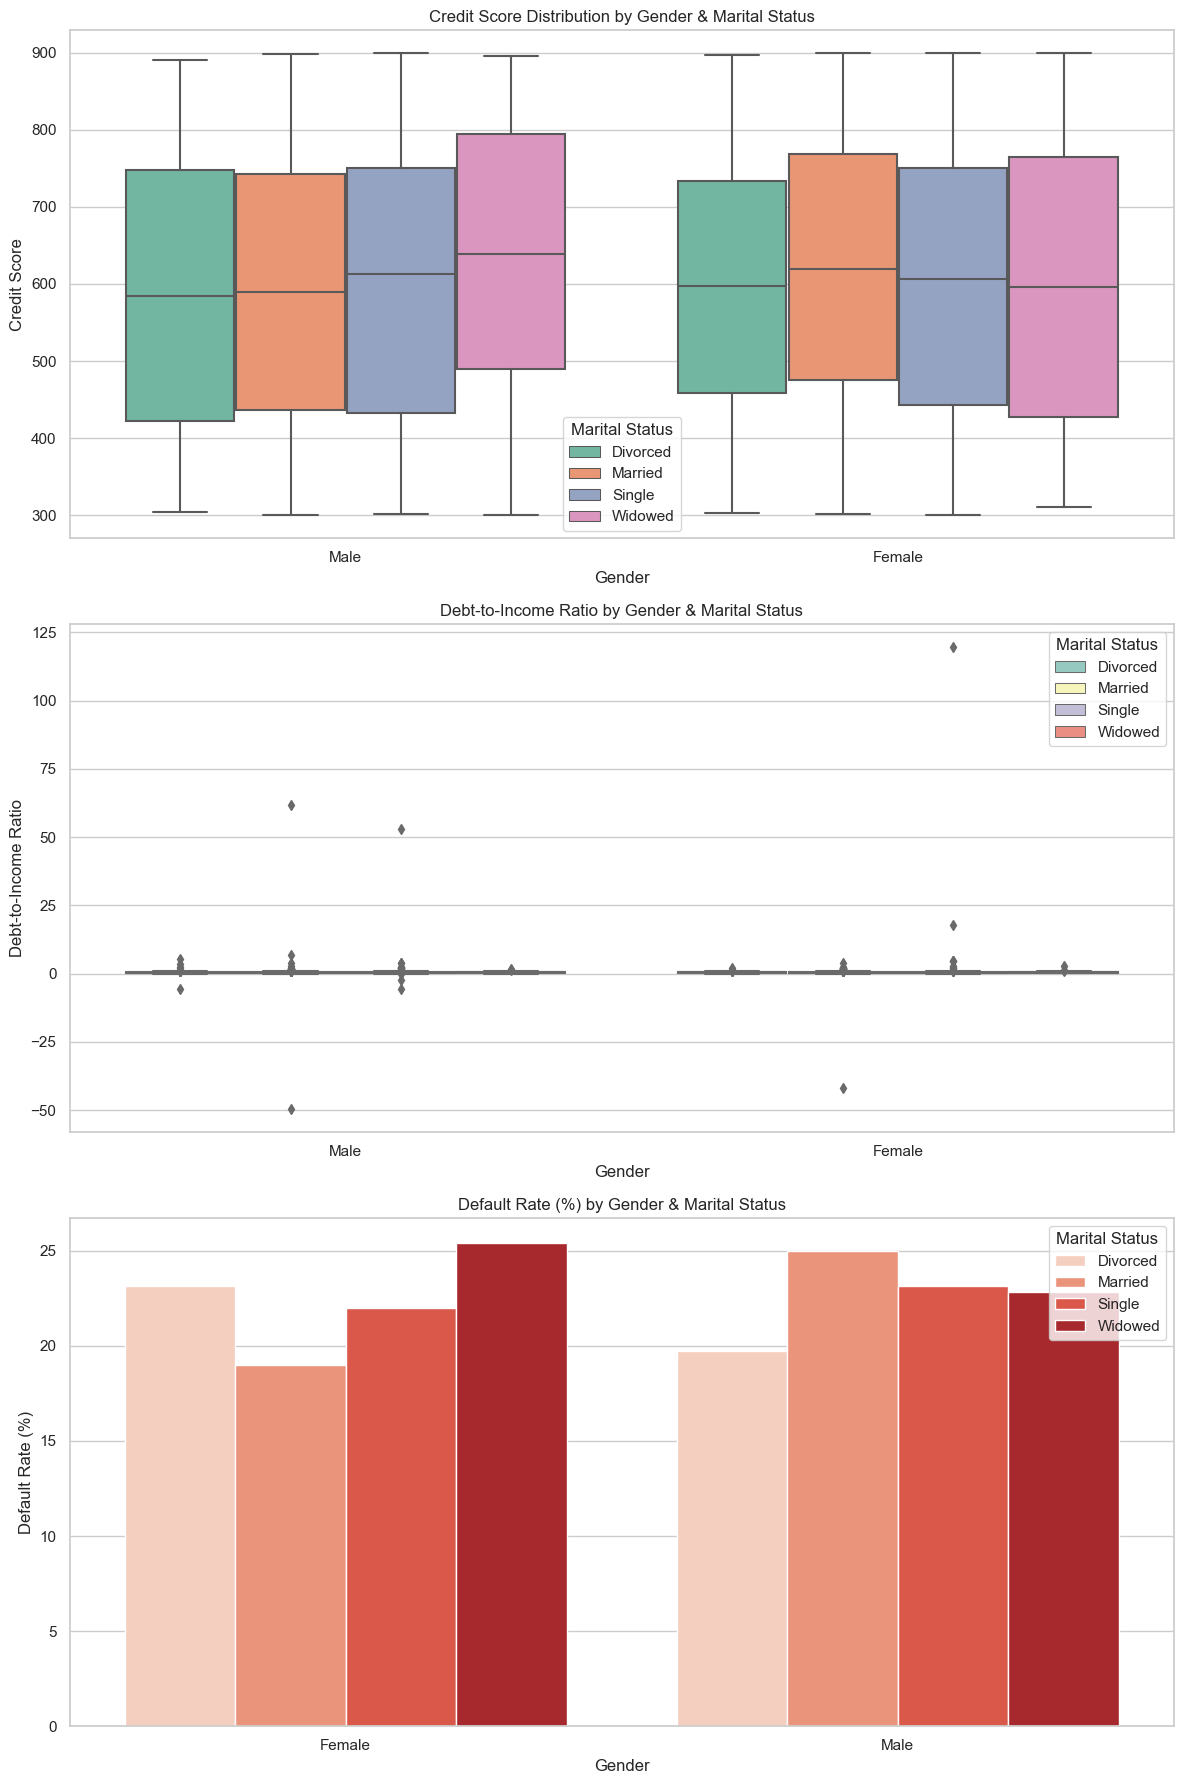

In [9]:

default_rate_df = (
    df
    .groupby(['gender', 'marital_status'], as_index=False)
    .agg(default_rate=('is_default', 'mean'))
)
default_rate_df['default_rate'] *= 100  


sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 18))


sns.boxplot(
    data=df,
    x='gender',
    y='credit_score',
    hue='marital_status',
    palette='Set2',
    ax=axes[0]
)
axes[0].set_title('Credit Score Distribution by Gender & Marital Status')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Credit Score')


sns.boxplot(
    data=df,
    x='gender',
    y='debt_to_income_ratio',
    hue='marital_status',
    palette='Set3',
    ax=axes[1]
)
axes[1].set_title('Debt-to-Income Ratio by Gender & Marital Status')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Debt-to-Income Ratio')


sns.barplot(
    data=default_rate_df,
    x='gender',
    y='default_rate',
    hue='marital_status',
    palette='Reds',
    ax=axes[2]
)
axes[2].set_title('Default Rate (%) by Gender & Marital Status')
axes[2].set_xlabel('Gender')
axes[2].set_ylabel('Default Rate (%)')

for ax in axes:
    ax.legend(title='Marital Status')

plt.tight_layout()
plt.show()


# Conclusion
Through this analysis, I, Sonal Khobragade, identified key behavioral and financial traits that impact loan defaults. It’s clear that income, credit score, and DTI are core drivers of risk, while education and employment status shape borrower stability. By uncovering regional and demographic trends, this study empowers lenders to fine-tune credit policies. These insights not only support smarter lending decisions but also help in building more inclusive financial systems. This project reinforced my belief in data-driven storytelling to solve real-world challenges.



##  Author

**Sonal Khobragade**  
Business Analyst | Data Enthusiast | Creative Writer  
🔗 [Portfolio] http://tinyurl.com/muv3wdmx
 [LinkedIn] https://www.linkedin.com/in/sonal-mk 
 [GitHub Repo] https://github.com/Sonal146/Loan-Default-Risk-Analysis-Project-